## TODO:
1. načtení dat (https://archive.ics.uci.edu/ml/datasets/wine) $X$ $[n \times d]$
2. rozdělení na train/test sady a standardizace
3. sestrojení kovarianční matice $P$
4. nalezení vlastních čísel a vlastních vektorů v matici $P$
5. seřazení vlastních vektorů ($\vec{\lambda}$) dle velikosti vlastních čísel ($\lambda$) (sestupně)
6. výběr $k$ vektorů $\vec{\lambda}$ s nejvyššími $\lambda$ ... $\rightarrow$ $\vec{\lambda}_{top}$
($k$ ... požadovaný počet principiálních komponent)
7. sestrojení projekční matice $W$ s rozměry $[d \times k]$ z $\vec{\lambda}_{top}$
8. transformace z $[n \times d]$ na $[n \times k]$ výpočtem $X\cdot W$

### 1. načtení dat

In [1]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### 2. rozdělení na train/test sady a standardizace

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# rozdělení na trénovací a testovací sadu
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# standardizace hodnot rysů (každý rys [sloupec] zvlášť)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

In [19]:
# ekvivalent X_train_std
X_train_std_manual = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)

### 3. sestrojení kovarianční matice
jelikož jsme standardizovali X: $mean(X) \tilde{=} 0$ ... lze kovarianční matici získat maticovým násobením $\frac{1}{N}\cdot(X^T\cdot X)$

jinak by to bylo:
$\frac{1}{N}[(X - mean(X))^T\cdot (X - mean(X))]$

In [50]:
import numpy as np

# výpočet kovarianční matice příkazem
cov_mat = np.cov(X_train_std, rowvar=False)

In [49]:
# manuální výpočet kovarianční matice
N = len(X_train_std)
cov_manual = np.matmul((X_train_std - X_train_std.mean(axis=0)).T, X_train_std - X_train_std.mean(axis=0))/N

### 4. výpočet vlastních čísel a vektorů

In [51]:
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

### 5 a 6. výpočet poměru variancí a výběr vlastních vektorů s nejvyššími hodnotami $\lambda$
vektory s nejvyšší variancí obsahují nejvíce informace o původních datech

variance odpovídá velikosti vlastního čísla

pro zachování nejvyššího množství informace se tedy volí $\vec{\lambda}$ s nejvyššími $\lambda$

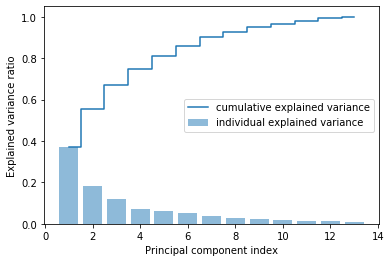

In [59]:
from matplotlib import pyplot as plt

# výpočet poměru variancí
total = sum(eigen_vals)
# míra vyjádřené variance v datech jednotlivými vlastními vektory
var_explained = [x/total for x in sorted(eigen_vals, reverse=True)]
# kumulativní míra vyjádřené variance
cum_var_exp = np.cumsum(var_explained)

# vykreslení poměru vyjádřených variancí
plt.bar(range(1,14), var_explained, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [60]:
# 1. vektor zachycuje cca 40% variance celých dat
# 2. vektor zachycuje cca 20% variance celých dat
# dohromady tedy zachycují 60% variance (informací) v datech

### 6. a 7. Seřazení a výběr vlastních vektorů a sestrojení transformační matice W

In [100]:
eigen_vecs.shape

(13, 13)

In [103]:
# Seřazení párů vlastních čísel a vlastních vektorů
eig_pairs = list(zip(np.abs(eigen_vals), eigen_vecs.T))

eig_pairs.sort(key=lambda x: x[0], reverse=True)

In [104]:
print(eig_pairs[0])
print(eigen_pairs[0])

(4.842745315655898, array([-0.13724218,  0.24724326, -0.02545159,  0.20694508, -0.15436582,
       -0.39376952, -0.41735106,  0.30572896, -0.30668347,  0.07554066,
       -0.32613263, -0.36861022, -0.29669651]))
(4.842745315655898, array([-0.13724218,  0.24724326, -0.02545159,  0.20694508, -0.15436582,
       -0.39376952, -0.41735106,  0.30572896, -0.30668347,  0.07554066,
       -0.32613263, -0.36861022, -0.29669651]))


In [105]:
# sestrojení transformační matice ze dvou vektorů s nejvyšší vyjadřovanou variancí
w = np.hstack((eig_pairs[0][1][:, np.newaxis], eig_pairs[1][1][:, np.newaxis]))

In [106]:
w

array([[-0.13724218,  0.50303478],
       [ 0.24724326,  0.16487119],
       [-0.02545159,  0.24456476],
       [ 0.20694508, -0.11352904],
       [-0.15436582,  0.28974518],
       [-0.39376952,  0.05080104],
       [-0.41735106, -0.02287338],
       [ 0.30572896,  0.09048885],
       [-0.30668347,  0.00835233],
       [ 0.07554066,  0.54977581],
       [-0.32613263, -0.20716433],
       [-0.36861022, -0.24902536],
       [-0.29669651,  0.38022942]])

### 8. Transformace do nové reprezantace dat principiálními komponenty

In [107]:
X_train_PCA = np.matmul(X_train_std,w)

### 9. Vizualizace nové dvourozměrné reprezentace dat

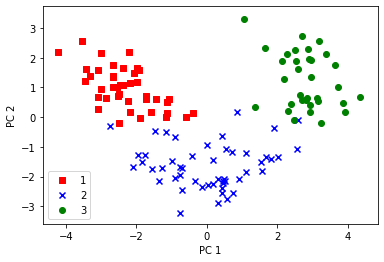

In [108]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_PCA[y_train==l, 0], 
                X_train_PCA[y_train==l, 1], 
                c=c, label=l, marker=m) 
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

### 10. PCA ve scikit-learn

In [109]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# inicializace PCA a logistické regrese
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='auto', solver='liblinear')

# trénování a transformace dat
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

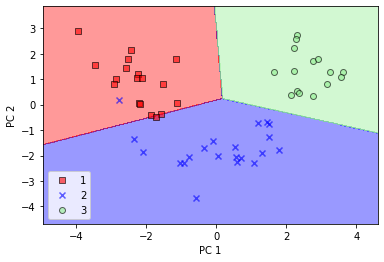

In [114]:
from matplotlib.colors import ListedColormap

from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=[cmap(idx)],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)# plot decision regions for training set


plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

### 11. Získání vyjadřované variance

In [115]:
pca = PCA(n_components=None)  # vrátí všechny principiální komponenty
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])